# Figures for _Global coastal wind hazard maps from the CHAZ tropical cyclone model_
In this notebook we plot the figures shown in the manuscript titled _Global coastal wind hazard maps from the CHAZ tropical cyclone model_ submitted to _Scientific Data_ by Meiler et al., 2025.

In [ ]:
import string
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.spatial import cKDTree
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from climada.util.constants import SYSTEM_DIR

# --- PATHS ---
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
fig_save_path = '/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/'

# --- CONFIG ---
region_bounds = {
    "Caribbean": [-100, -40, 5, 40],
    "Southeast Asia": [90, 150, 5, 30],
    "Global": [-180, 180, -90, 90]
}

In [2]:
# --- LOAD LAND SHAPE ---
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

### Fig. 1. Global coastal 100-yr tropical cyclone wind exceedance intensities for the historical period

In [ ]:
selected_region = "Global"

# --- PATH ---
netcdf_path = haz_dir / f"TC_global_0300as_CHAZ_ERA5_exceedance_intensity.nc"

# --- CONFIG ---
metric_key = "rp_100"

# --- LOAD DATA ---
ds = xr.open_dataset(netcdf_path)
lat = ds["lat"].values
lon = ds["lon"].values
values = ds[metric_key].values

# --- CREATE GEODATAFRAME ---
df = pd.DataFrame({"lat": lat, "lon": lon, "value": values})
df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# --- CLIP TO LAND ---
gdf = gpd.clip(gdf, land)

# --- FILTER TO REGION ---
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]
gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

# Mask 0 or NaN values
masked_vals = np.ma.masked_where((gdf["value"] <= 0) | (gdf["value"].isna()), gdf["value"])
# Choose colormap
cmap = plt.get_cmap("Oranges").copy()
cmap.set_bad("lightgrey")  # grey for masked areas (like zero)

# --- Define your cities of interest ---
cities = {
    "Noumea":    {"lon": 166.45,  "lat": -22.28},
    "Miami":     {"lon": -80.2,   "lat": 25.8},
    "Acapulco":  {"lon": -99.9,   "lat": 16.8},
    "Toamasina": {"lon": 49.37,   "lat": -18.15},
    "Mumbai":    {"lon": 72.8,    "lat": 18.9},
    "Manila":    {"lon": 121.0,   "lat": 14.6}
}

/Users/simonameiler/miniforge3/envs/climada_env/lib/python3.11/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


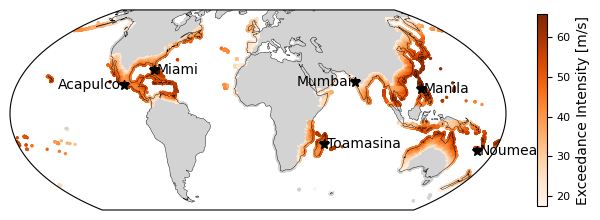

In [ ]:
# Plot setup
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': ccrs.Mollweide()})

# Apply font sizes for publication
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})

# Add land and borders, but no globe outline
ax.add_feature(cfeature.LAND, facecolor="lightgrey", zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

# Add data points (gdf scatter)
sc = ax.scatter(
    gdf["lon"], gdf["lat"], c=masked_vals,
    cmap=cmap, s=2, transform=ccrs.PlateCarree()
)

# Add cities as stars with labels (some offset left)
for name, coords in cities.items():
    if name in ["Acapulco", "Mumbai"]:
        # Offset to the left
        ax.text(coords["lon"] - 2, coords["lat"], name, color='black',
                transform=ccrs.PlateCarree(), ha='right', va='center')
    else:
        # Default: offset to the right
        ax.text(coords["lon"] + 2, coords["lat"], name, color='black',
                transform=ccrs.PlateCarree(), ha='left', va='center')
    
    # Plot the star marker
    ax.plot(coords["lon"], coords["lat"], marker='*', color='black',
            markersize=7, transform=ccrs.PlateCarree())
#ax.set_axis_off()

# Colorbar and title
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label("Exceedance Intensity [m/s]")

# Save or show figure
save_fig_str = f'ERA5-global_exceedence_intensity_RP100_cities.png'
plt.savefig(
    fig_save_path + save_fig_str,
    dpi=300,
    facecolor='w',
    edgecolor='w',
    orientation='portrait',
    format='png',
    bbox_inches='tight',
    pad_inches=0.1
)


## Figures 2 and 3: Exceedance intensity maps for RP100 - per GCM

In [9]:
# --- CONFIG ---
models = [
    "CESM2", "CNRM-CM6-1", "EC-Earth3", "IPSL-CM6A-LR",
    "MIROC6", "MPI-ESM1-2-HR", "UKESM1-0-LL"
]
scenarios = ["ssp245", "ssp370", "ssp585"]
periods = ["base", "fut1", "fut2"]
tcgi = "SD"
metric_key = "rp_100"
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
region_bounds = {
    "Caribbean": [-100, -40, 5, 40],
    "Southeast Asia": [90, 150, 5, 30],
    "Global": [-180, 180, -90, 90]
}
selected_region = "Caribbean"
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]

Compute multi-model medians

In [ ]:
median_maps_intensity = {}

for period in periods:
    for scenario in scenarios:
        all_model_vals = []

        for model in models:
            file = f"TC_global_0300as_CHAZ_{model}_{period}_{scenario}_80ens_{tcgi}_H08_exceedance_intensity.nc"
            path = haz_dir / file
            if not path.exists():
                continue

            try:
                ds = xr.open_dataset(path)
                if metric_key not in ds:
                    continue

                df = pd.DataFrame({
                    "lat": ds["lat"].values,
                    "lon": ds["lon"].values,
                    metric_key: ds[metric_key].values
                })
                df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
                gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

                gdf = gpd.clip(gdf, land)
                gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

                if not gdf.empty:
                    gdf = gdf.set_index(["lat", "lon"])
                    all_model_vals.append(gdf[metric_key])

            except Exception as e:
                print(f"Error loading {file}: {e}")

        if all_model_vals:
            merged = pd.concat(all_model_vals, axis=1)
            median_vals = merged.median(axis=1).reset_index()
            median_vals.rename(columns={0: metric_key}, inplace=True)
            median_vals["geometry"] = [Point(xy) for xy in zip(median_vals.lon, median_vals.lat)]
            gdf_median = gpd.GeoDataFrame(median_vals, geometry="geometry", crs="EPSG:4326")
            median_maps_intensity[(period, scenario)] = gdf_median


In [7]:
era5_path = haz_dir / "TC_global_0300as_CHAZ_ERA5_exceedance_intensity.nc"

ds = xr.open_dataset(era5_path)
df = pd.DataFrame({
    "lat": ds["lat"].values,
    "lon": ds["lon"].values,
    metric_key: ds[metric_key].values
})
df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf_era5 = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf_era5 = gpd.clip(gdf_era5, land)
gdf_era5 = gdf_era5.cx[min_lon:max_lon, min_lat:max_lat]

gdf_base = median_maps_intensity.get(("base", "ssp245"))

# --- Step 1: Snap ERA5 coordinates to GCM grid ---
gcm_coords = gdf_base[["lat", "lon"]].drop_duplicates().values
tree = cKDTree(gcm_coords)
era5_coords = gdf_era5[["lat", "lon"]].values
_, idxs = tree.query(era5_coords)

gdf_era5_snapped = gdf_era5.copy()
gdf_era5_snapped["lat"] = gcm_coords[idxs][:, 0]
gdf_era5_snapped["lon"] = gcm_coords[idxs][:, 1]

# --- Step 2: Restrict to shared snapped coordinates ---
shared_coords = pd.merge(
    gdf_era5_snapped[["lat", "lon"]],
    gdf_base[["lat", "lon"]],
    on=["lat", "lon"]
).drop_duplicates()

gdf_era5_matched = gdf_era5_snapped.merge(shared_coords, on=["lat", "lon"])
gdf_base_matched = gdf_base.merge(shared_coords, on=["lat", "lon"])

# --- Step 3: Merge for ERA5 vs BASE comparison ---
df_merged_era5_vs_base = gdf_base_matched.set_index(["lat", "lon"]).join(
    gdf_era5_matched.set_index(["lat", "lon"]),
    lsuffix="_gcm", rsuffix="_era5"
)

/Users/simonameiler/miniforge3/envs/climada_env/lib/python3.11/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


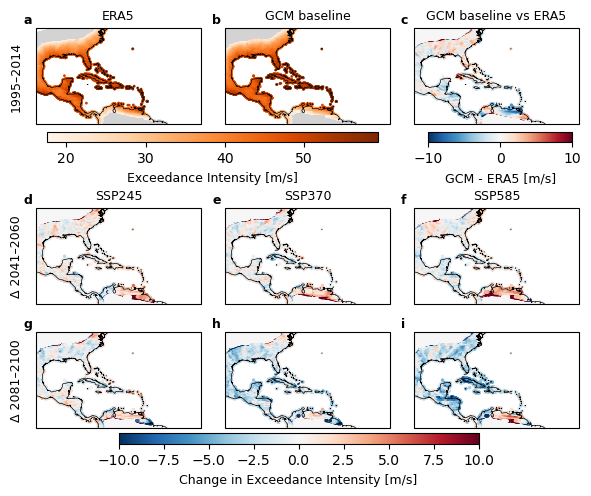

In [8]:
# --- Styling and layout ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.35)

period_rows = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

# Colormaps
cmap_abs = plt.get_cmap("Oranges").copy()
cmap_abs.set_bad("lightgrey")
cmap_diff = plt.get_cmap("RdBu_r").copy()
cmap_diff.set_bad("lightgrey")
vmin_diff, vmax_diff = -10, 10

scatter_refs = {"abs": None, "diff": None}

axs = []

# --- Panel 1 (ERA5) ---
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
try:
    masked_vals = np.ma.masked_where((gdf_era5[metric_key] <= 0) | (gdf_era5[metric_key].isna()), gdf_era5[metric_key])
    sc = ax0.scatter(
        gdf_era5["lon"], gdf_era5["lat"], c=masked_vals,
        cmap=cmap_abs, s=1, transform=ccrs.PlateCarree()
    )
    scatter_refs["abs"] = sc
except Exception as e:
    print(f"Error loading ERA5: {e}")

ax0.set_title("ERA5", fontsize=fontsize)
ax0.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax0.coastlines(linewidth=0.5)
ax0.text(
    -0.08, 0.5, period_labels["base"],
    transform=ax0.transAxes, rotation=90,
    fontsize=fontsize, va='center', ha='right'
)
axs.append(ax0)

# --- Panel 2 (GCM baseline SSP245) ---
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
gdf_base = median_maps_intensity.get(("base", "ssp245"))
if gdf_base is not None:
    masked_vals = np.ma.masked_where((gdf_base[metric_key] <= 0) | (gdf_base[metric_key].isna()), gdf_base[metric_key])
    sc = ax1.scatter(
        gdf_base["lon"], gdf_base["lat"], c=masked_vals,
        cmap=cmap_abs, s=1, transform=ccrs.PlateCarree()
    )
    scatter_refs["abs"] = sc

ax1.set_title("GCM baseline", fontsize=fontsize)
ax1.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax1.coastlines(linewidth=0.5)
axs.append(ax1)

# --- Panel 3 (ERA5 vs GCM baseline % difference) ---
ax2 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
if not df_merged_era5_vs_base.empty:
    diff_vals = df_merged_era5_vs_base[f"{metric_key}_gcm"] - df_merged_era5_vs_base[f"{metric_key}_era5"]
    masked_vals = np.ma.masked_where(diff_vals.isna(), diff_vals)

    coords = df_merged_era5_vs_base.index.to_frame(index=False)
    sc = ax2.scatter(
        coords["lon"], coords["lat"], c=masked_vals,
        cmap=cmap_diff, vmin=vmin_diff, vmax=vmax_diff,
        s=2, transform=ccrs.PlateCarree()
    )
    scatter_refs["diff"] = sc

ax2.set_title("GCM baseline vs ERA5", fontsize=fontsize)
ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax2.coastlines(linewidth=0.5)
axs.append(ax2)

# --- Main grid for FUTURE rows (fut1 & fut2) ---
for i, period in enumerate(["fut1", "fut2"], start=2):  # rows 2 and 3
    for j, scenario in enumerate(scenarios):
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        axs.append(ax)

        gdf = median_maps_intensity.get((period, scenario))
        gdf_base = median_maps_intensity.get(("base", "ssp245"))

        if gdf is not None and gdf_base is not None:
            df_merged = gdf.set_index(["lat", "lon"]).join(
                gdf_base.set_index(["lat", "lon"]),
                lsuffix="_fut", rsuffix="_base"
            )
            diff_vals = df_merged[f"{metric_key}_fut"] - df_merged[f"{metric_key}_base"]
            masked_vals = np.ma.masked_where(diff_vals.isna(), diff_vals)

            coords = df_merged.index.to_frame(index=False)
            sc = ax.scatter(
                coords["lon"], coords["lat"], c=masked_vals,
                cmap=cmap_diff, vmin=vmin_diff, vmax=vmax_diff,
                s=2, transform=ccrs.PlateCarree()
            )
            if scatter_refs["diff"] is None:
                scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 2:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

labels = list(string.ascii_lowercase)[:len(axs)]  
for lbl, ax in zip(labels, axs):
    ax.text(
        -0.08, 1.05, lbl,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
    )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.15, 0.66, 0.46, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal')
    cbar.set_label("Exceedance Intensity [m/s]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    cbar_diff.set_label("Change in Exceedance Intensity [m/s]", fontsize=fontsize)

# --- Colorbar for Panel 3 (GCM baseline vs ERA5) ---
cbar_ax_top_diff = fig.add_axes([0.68, 0.66, 0.2, 0.02])  # [left, bottom, width, height]
cbar_top_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_top_diff, orientation='horizontal')
cbar_top_diff.set_label("GCM - ERA5 [m/s]", fontsize=fontsize)

#plt.tight_layout(rect=[0.03, 0.14, 1, 0.95])
plt.show()

# --- Save to file ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/exceedance_intensity_{metric_key}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')



## Figures 4 and 5: Return period maps of Cat. 1 TCs - per GCM

In [ ]:
# --- CONFIG ---
models = [
    "CESM2", "CNRM-CM6-1", "EC-Earth3", "IPSL-CM6A-LR",
    "MIROC6", "MPI-ESM1-2-HR", "UKESM1-0-LL"
]
scenarios = ["ssp245", "ssp370", "ssp585"]
periods = ["base", "fut1", "fut2"]
tcgi = "CRH"
threshold = 33
metric_key = f"thr_{threshold}"

selected_region = "Southeast Asia"
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]


In [ ]:
# Store median GeoDataFrames per period/scenario
median_maps = {}

for period in periods:
    for scenario in scenarios:
        all_model_vals = []

        for model in models:
            file = f"TC_global_0300as_CHAZ_{model}_{period}_{scenario}_80ens_{tcgi}_H08_return_periods.nc"
            path = haz_dir / file
            if not path.exists():
                continue

            try:
                ds = xr.open_dataset(path)
                if metric_key not in ds:
                    continue

                df = pd.DataFrame({
                    "lat": ds["lat"].values,
                    "lon": ds["lon"].values,
                    metric_key: ds[metric_key].values
                })
                df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
                gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

                gdf = gpd.clip(gdf, land)
                gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

                if not gdf.empty:
                    gdf = gdf.set_index(["lat", "lon"])
                    all_model_vals.append(gdf[metric_key])

            except Exception as e:
                print(f"Error loading {file}: {e}")

        if all_model_vals:
            merged = pd.concat(all_model_vals, axis=1)
            median_vals = merged.median(axis=1).reset_index()
            median_vals.rename(columns={0: metric_key}, inplace=True)
            median_vals["geometry"] = [Point(xy) for xy in zip(median_vals.lon, median_vals.lat)]
            gdf_median = gpd.GeoDataFrame(median_vals, geometry="geometry", crs="EPSG:4326")
            median_maps[(period, scenario)] = gdf_median


In [ ]:
era5_path = haz_dir / "TC_global_0300as_CHAZ_ERA5_return_periods.nc"

ds = xr.open_dataset(era5_path)
df = pd.DataFrame({
    "lat": ds["lat"].values,
    "lon": ds["lon"].values,
    metric_key: ds[metric_key].values
})
df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf_era5 = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf_era5 = gpd.clip(gdf_era5, land)
gdf_era5 = gdf_era5.cx[min_lon:max_lon, min_lat:max_lat]

gdf_base = median_maps.get(("base", "ssp245"))

# --- Step 1: Snap ERA5 coordinates to GCM grid ---
gcm_coords = gdf_base[["lat", "lon"]].drop_duplicates().values
tree = cKDTree(gcm_coords)
era5_coords = gdf_era5[["lat", "lon"]].values
_, idxs = tree.query(era5_coords)

gdf_era5_snapped = gdf_era5.copy()
gdf_era5_snapped["lat"] = gcm_coords[idxs][:, 0]
gdf_era5_snapped["lon"] = gcm_coords[idxs][:, 1]

# --- Step 2: Restrict to shared snapped coordinates ---
shared_coords = pd.merge(
    gdf_era5_snapped[["lat", "lon"]],
    gdf_base[["lat", "lon"]],
    on=["lat", "lon"]
).drop_duplicates()

gdf_era5_matched = gdf_era5_snapped.merge(shared_coords, on=["lat", "lon"])
gdf_base_matched = gdf_base.merge(shared_coords, on=["lat", "lon"])

# --- Step 3: Merge for ERA5 vs BASE comparison ---
df_merged_era5_vs_base = gdf_base_matched.set_index(["lat", "lon"]).join(
    gdf_era5_matched.set_index(["lat", "lon"]),
    lsuffix="_gcm", rsuffix="_era5"
)

Saved: /Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_ratio_thr_33_CRH.png


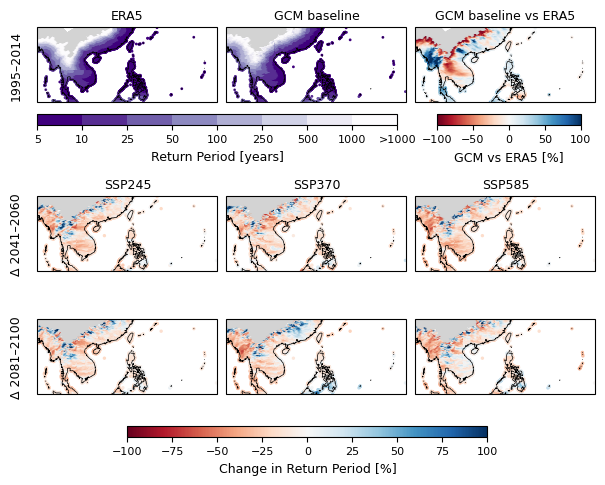

In [ ]:
# --- Setup ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))

# RP settings
bins = [5, 10, 25, 50, 100, 250, 500, 1000, 10000]
log_bins = np.log10(bins)
tick_labels = [str(b) for b in bins[:-1]] + [">1000"]
norm_abs = mcolors.BoundaryNorm(log_bins, ncolors=len(bins) - 1)
cmap_abs = plt.get_cmap("Purples_r", len(bins) - 1)
cmap_abs.set_bad("lightgrey")

# % diff colorbar
cmap_diff = plt.get_cmap("RdBu").copy()
cmap_diff.set_bad("lightgrey")
vmin_pct, vmax_pct = -100, 100  # clip percent changes

# Periods and labels
periods = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

scatter_refs = {"abs": None, "diff": None}

axs = []

# Unified 3x3 layout
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.15)

# --- Panel 1 (ERA5) ---
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
try:
    log_vals = np.log10(gdf_era5[metric_key])
    masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

    sc = ax0.scatter(
        gdf_era5["lon"], gdf_era5["lat"], c=masked_vals,
        cmap=cmap_abs, s=1, transform=ccrs.PlateCarree(), norm=norm_abs
    )
    scatter_refs["abs"] = sc
except Exception as e:
    print(f"Error loading ERA5: {e}")

ax0.set_title("ERA5", fontsize=fontsize)
ax0.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax0.coastlines(linewidth=0.5)
ax0.text(
    -0.08, 0.5, period_labels["base"],
    transform=ax0.transAxes, rotation=90,
    fontsize=fontsize, va='center', ha='right'
)
axs.append(ax0)

# --- Panel 2 (GCM baseline SSP245) ---
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
gdf_base = median_maps.get(("base", "ssp245"))
if gdf_base is not None:
    log_vals = np.log10(gdf_base[metric_key])
    masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

    sc = ax1.scatter(
        gdf_base["lon"], gdf_base["lat"], c=masked_vals,
        cmap=cmap_abs, s=1, transform=ccrs.PlateCarree(), norm=norm_abs
    )
    scatter_refs["abs"] = sc

ax1.set_title("GCM baseline", fontsize=fontsize)
ax1.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax1.coastlines(linewidth=0.5)
axs.append(ax1)

# --- Panel 3 (ERA5 vs GCM baseline % difference) ---
ax2 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())

if not df_merged_era5_vs_base.empty:
    val_gcm = df_merged_era5_vs_base[f"{metric_key}_gcm"]
    val_era5 = df_merged_era5_vs_base[f"{metric_key}_era5"]

    pct_diff = ((val_gcm - val_era5) / val_era5) * 100
    pct_diff = pct_diff.clip(lower=vmin_pct, upper=vmax_pct)
    masked_vals = np.ma.masked_where(pct_diff.isna(), pct_diff)

    coords = df_merged_era5_vs_base.index.to_frame(index=False)

    sc = ax2.scatter(
        coords["lon"], coords["lat"], c=masked_vals,
        cmap=cmap_diff, vmin=vmin_pct, vmax=vmax_pct,
        s=2, transform=ccrs.PlateCarree()
    )
    scatter_refs["diff"] = sc

ax2.set_title("GCM baseline vs ERA5", fontsize=fontsize)
ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax2.coastlines(linewidth=0.5)
axs.append(ax2)

# --- Main grid for FUTURE rows (fut1 & fut2) ---
for i, period in enumerate(["fut1", "fut2"], start=2):  # rows 2 and 3
    for j, scenario in enumerate(scenarios):
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        axs.append(ax)

        gdf = median_maps.get((period, scenario))
        gdf_base = median_maps.get(("base", "ssp245"))  # <--- use fixed baseline for all

        if gdf is not None and gdf_base is not None:
            df_merged = gdf.set_index(["lat", "lon"]).join(
                gdf_base.set_index(["lat", "lon"]),
                lsuffix="_fut", rsuffix="_base"
            )
            base_vals = df_merged[f"{metric_key}_base"]
            fut_vals = df_merged[f"{metric_key}_fut"]
            pct_change = ((fut_vals - base_vals) / base_vals) * 100
            pct_change = pct_change.clip(lower=vmin_pct, upper=vmax_pct)
            masked_vals = np.ma.masked_where(pct_change.isna(), pct_change)

            coords = df_merged.index.to_frame(index=False)
            sc = ax.scatter(
                coords["lon"], coords["lat"], c=masked_vals,
                cmap=cmap_diff, vmin=vmin_pct, vmax=vmax_pct,
                s=2, transform=ccrs.PlateCarree()
            )
            if scatter_refs["diff"] is None:
                scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 2:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

labels = list(string.ascii_lowercase)[:len(axs)]  
for lbl, ax in zip(labels, axs):
    ax.text(
        -0.08, 1.05, lbl,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
    )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.125, 0.66, 0.5, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal', ticks=log_bins)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label("Return Period [years]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.06, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    cbar_diff.set_label("Change in Return Period [%]", fontsize=fontsize)

# --- Colorbar for Panel 3 (GCM baseline vs ERA5) ---
cbar_ax_top_diff = fig.add_axes([0.68, 0.66, 0.2, 0.02])  # [left, bottom, width, height]
cbar_top_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_top_diff, orientation='horizontal')
cbar_top_diff.set_label("GCM vs ERA5 [%]", fontsize=fontsize)

# --- Save ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_{metric_key}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {output_path}")
